<a href="https://colab.research.google.com/github/nasarahj/HealthDatasetProject/blob/main/Heart_Prediction_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
!pip install -U ucimlrepo
from ucimlrepo import fetch_ucirepo
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [2]:
#Use ID to fetch dataset
heart_disease = fetch_ucirepo(id=45)

#get features (x) and targets (y) as pandas dataframe
x = heart_disease.data.features
y = heart_disease.data.targets

#combine into one dataset
df = pd.concat([x, y], axis=1)

#display few rows
print('Preview of Data')
print(df.head())

#get metadata
print('Variables')
print(heart_disease.variables)
print('Metadata')
print(heart_disease.metadata)

Preview of Data
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   1       145   233    1        2      150      0      2.3      3   
1   67    1   4       160   286    0        2      108      1      1.5      2   
2   67    1   4       120   229    0        2      129      1      2.6      2   
3   37    1   3       130   250    0        0      187      0      3.5      3   
4   41    0   2       130   204    0        2      172      0      1.4      1   

    ca  thal  num  
0  0.0   6.0    0  
1  3.0   3.0    2  
2  2.0   7.0    1  
3  0.0   3.0    0  
4  0.0   3.0    0  
Variables
        name     role         type demographic  \
0        age  Feature      Integer         Age   
1        sex  Feature  Categorical         Sex   
2         cp  Feature  Categorical        None   
3   trestbps  Feature      Integer        None   
4       chol  Feature      Integer        None   
5        fbs  Feature  Categorical        None   
6    restecg  Fea

**Variables**

**Age** - Range 29-77

**Sex** - Male/Female

**CP (Chest Pain)** - Type of chest pain.

1 = Typical angina

2 = Atypical angina

3 = Non-anginal pain

4 = Asymptomatic (no pain)

**Trestbps (Resting blood pressure)** - normal range 90-120

** Chol** Normal cholestorol range is under 200.

** FBS (Fasting Blood Sugar)** - High Yes=1 No=0

**Restecg (resting ECG results)** -

0 = Normal ECG

1 = ST-T wave abnormality

2 = Left ventricular hypertrophy

**Thalach (maximum heart rate achieved)** - Typical 70-200

** Exang (exercise-induced angina)** - 1 - Yes (angina induced by exercise), 0-No

** Oldpeak (ST depression induced by exercise)**
Amount of ST segment depression (ECG finding)

Clinical Insight:
Indicates ischemia — lower oxygen supply to heart muscle.
Higher oldpeak correlates with worse obstruction.

** slope (slope of peak exercise ST segment)**

1 = Upsloping

2 = Flat (most concerning)

3 = Downsloping (high risk)

Clinical Insight:

Flat or downsloping ST segment indicates ischemia.

**Ca (number of major vessels colored by fluoroscopy)**

Number of major coronary arteries with blockage visible
Values: 0–3
Clinical Insight:

Higher = more blocked arteries

One of the most powerful predictors

**thal (thalassemia / stress test result)**

3 = Normal

6 = Fixed defect

7 = Reversible defect

Clinical Insight:

Reversible defect = ischemia

Fixed defect = scar tissue

**num (target variable)** - 0 = No heart disease

1,2,3,4 = Levels of disease severity


In [3]:
#check for missing data
missing_data = df.isnull().sum()
print(missing_data)

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
num         0
dtype: int64


In [4]:
df.duplicated().sum()
#check for duplicates


np.int64(0)

In [5]:
#summary stats
print(df.describe())

              age         sex          cp    trestbps        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    54.438944    0.679868    3.158416  131.689769  246.693069    0.148515   
std      9.038662    0.467299    0.960126   17.599748   51.776918    0.356198   
min     29.000000    0.000000    1.000000   94.000000  126.000000    0.000000   
25%     48.000000    0.000000    3.000000  120.000000  211.000000    0.000000   
50%     56.000000    1.000000    3.000000  130.000000  241.000000    0.000000   
75%     61.000000    1.000000    4.000000  140.000000  275.000000    0.000000   
max     77.000000    1.000000    4.000000  200.000000  564.000000    1.000000   

          restecg     thalach       exang     oldpeak       slope          ca  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  299.000000   
mean     0.990099  149.607261    0.326733    1.039604    1.600660    0.672241   
std      0.994971   22.8750

There are possible outliers in Homa Leptin, Resistin, and MCP.1 columns that I would like to explore

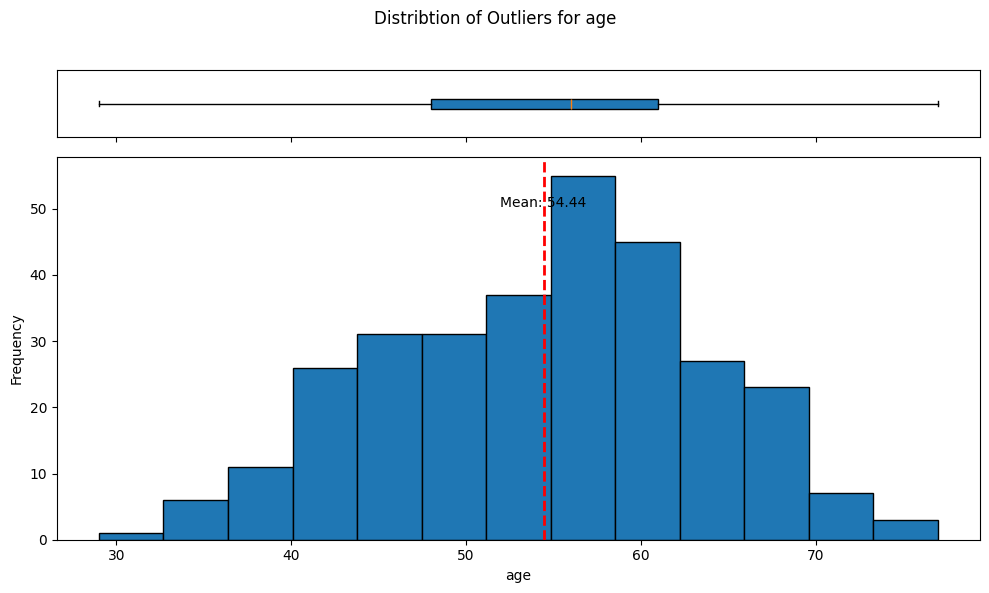

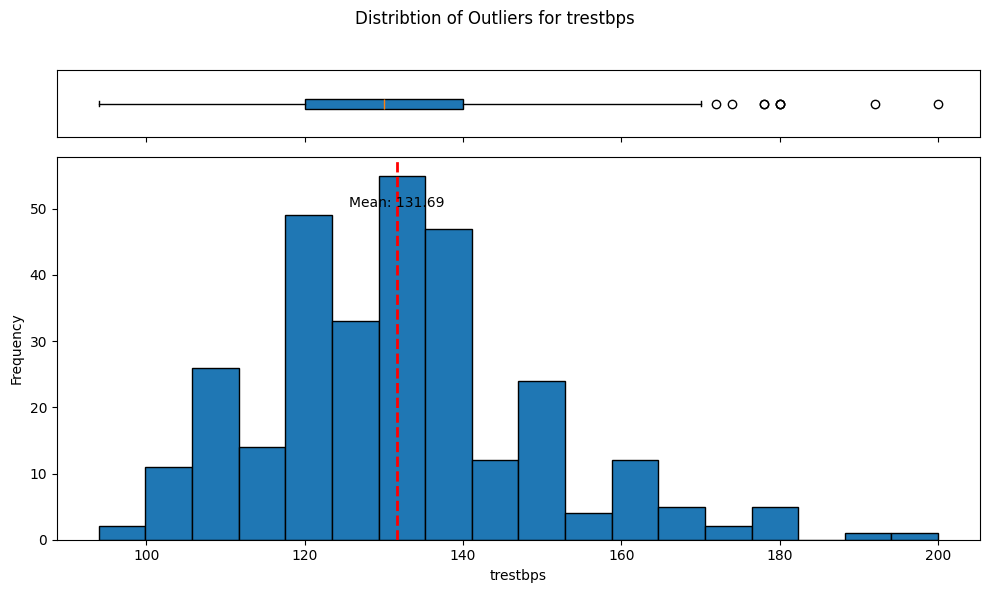

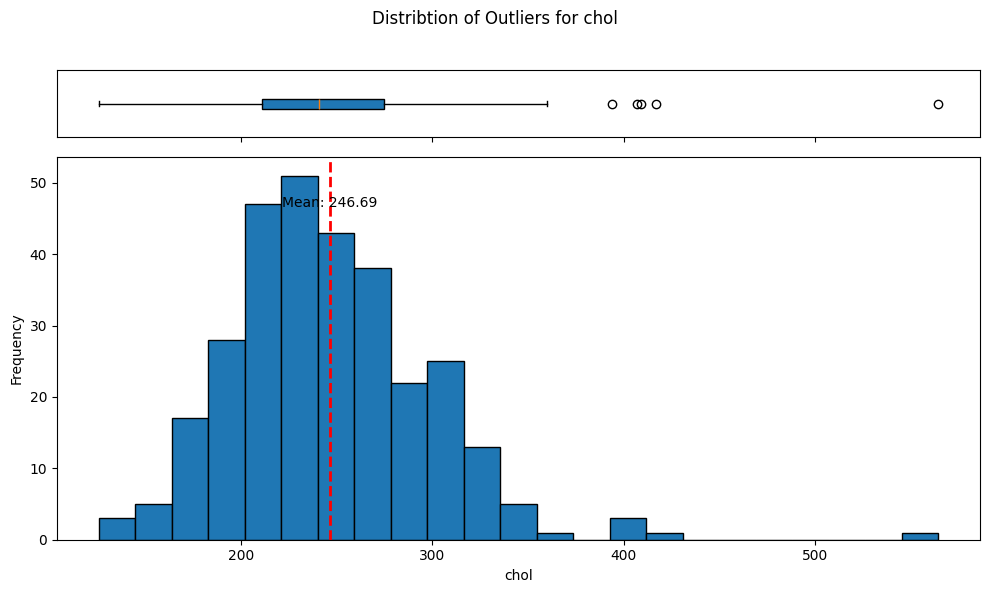

In [6]:
#create box plot and histogram

def plot_outliers (df, column):
  fig, (ax_box, ax_hist) = plt.subplots(2,1, sharex=True,
        gridspec_kw={'height_ratios': (0.15, 0.85)},figsize=(10,6)
  )
  fig.suptitle(f'Distribtion of Outliers for {column}')

  #BOX PLOT
  ax_box.boxplot(df[column].dropna(), vert=False, patch_artist=True)
  ax_box.set(yticks=[]) #remove y-axis labels

  #HISTOGRAM
  ax_hist.hist(df[column].dropna(), bins='auto', edgecolor='black')
  ax_hist.set(xlabel=column, ylabel='Frequency')

  #add verticle line for mean value
  mean_value = df[column].mean()
  ax_hist.axvline(mean_value, color='red', linestyle='dashed', linewidth=2)
  ax_hist.text(mean_value, ax_hist.get_ylim()[1]*0.9, f'Mean: {mean_value:.2f}', ha='center', va='top')

  plt.tight_layout(rect=[0,0,1,0.96])
  plt.show()


numeric_cols = [
    'age', 'trestbps', 'chol',
]

for col in numeric_cols:
    plot_outliers(df, col)

In both the bar plot and histograms we see that there are outliers present for each field tested. Instead of deleting the outliers, we will keep it because it is medically possible and does not skew the results.  

In [7]:
#change the target, num, to binary classification
df['num'] = df["num"].apply(lambda x: 1 if x > 0 else 0)


In [8]:
#seperating categorical columns and numeric
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
numeric_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']


In [9]:
#change categorical into binary
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


In [10]:
#split dataset features and targets
X = df_encoded.drop('num', axis=1)
y = df_encoded['num']


In [11]:
#split into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [12]:

scaler = StandardScaler()
#scale the training data
X_train_scaled = scaler.fit_transform(X_train[numeric_cols])
#transform test data
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

I have finished the preprocessing and now I will move to training my four models: Logistic regression, kneighbors, decision tree, random forest

In [13]:
#create dictionary for models
models = {
    'Logistic Regression': LogisticRegression(max_iter=2000,class_weight='balanced'),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42,class_weight='balanced')
}

model_results = {} #dictionary that holds results

for name, model in models.items():
  model.fit(X_train, y_train)
  preds = model.predict(X_test)
  probs = model.predict_proba(X_test)[:,1]

  model_results[name] = {
      'accuracy': accuracy_score(y_test, preds),
      'precision': precision_score(y_test, preds),
      'recall': recall_score(y_test, preds),
      'f1': f1_score(y_test, preds),
      'roc_auc': roc_auc_score(y_test, probs)
  }

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [14]:
results_df = pd.DataFrame(model_results).T
results_df



,accuracy,precision,recall,f1,roc_auc
Logistic Regression,0.868852,0.884615,0.821429,0.851852,0.952381
K-Nearest Neighbors,0.540984,0.000000,0.000000,0.000000,0.500000
Decision Tree,0.442623,0.450000,0.964286,0.613636,0.482143
Random Forest,0.836066,0.875000,0.750000,0.807692,0.926948


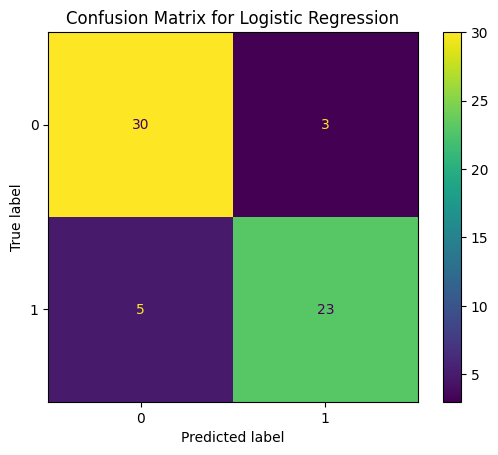

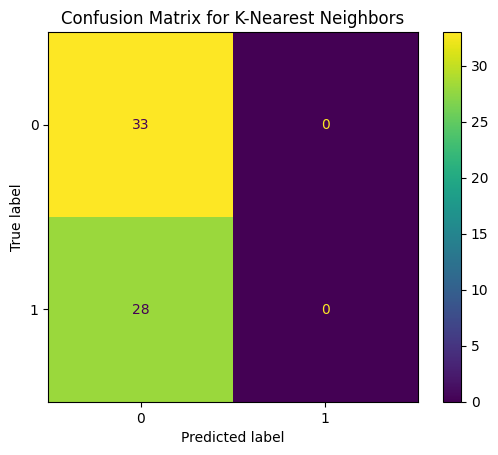

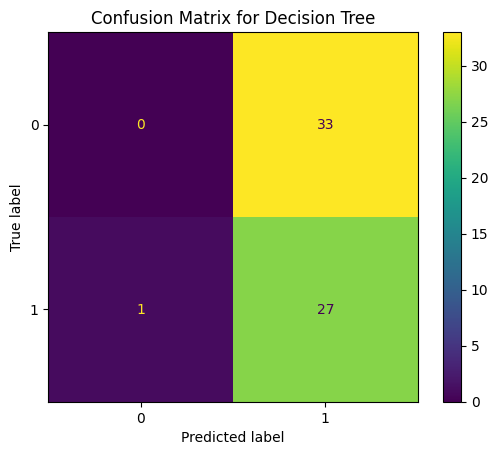

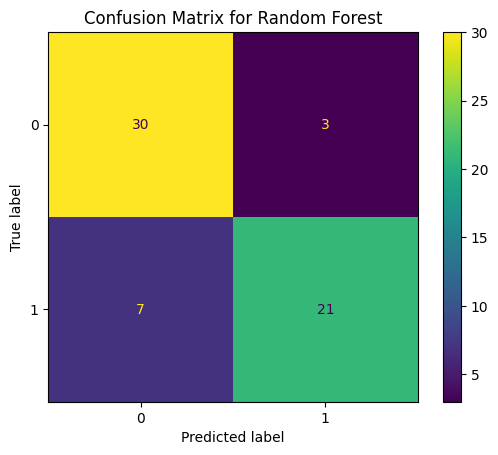

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

for name, model in models.items():
  preds = model.predict(X_test)

  cm = confusion_matrix(y_test, preds)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.title(f'Confusion Matrix for {name}')
  plt.show()

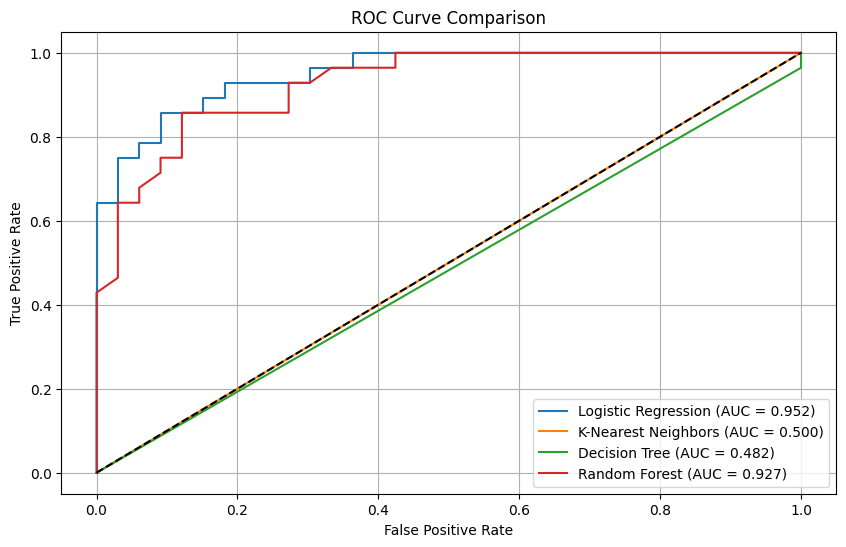

In [20]:
  plt.figure(figsize=(10, 6))

for name, model in models.items():
    probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_test, probs):.3f})")

plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid()
plt.show()


In [21]:
#Find the best model using AUC
best_model = results_df.sort_values(by="roc_auc", ascending=False).head(1)
best_model

,accuracy,precision,recall,f1,roc_auc
Logistic Regression,0.868852,0.884615,0.821429,0.851852,0.952381


In [28]:
#save best model for streamlit deployment
import joblib

best_lr = model

joblib.dump(best_lr, "best_logistic_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(X_train.columns.tolist(), "feature_columns.pkl")

print("Artifacts saved!")


Artifacts saved!
